In [3]:
import random
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
words = open('../data/names.txt', 'r').read().splitlines()

In [5]:
# vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
g = torch.Generator().manual_seed(2147483647)

In [7]:
# dataset
block_size = 3


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [44]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)

        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, input_size, emb_size):
        self.C = torch.randn((input_size, emb_size), generator=g)

    def __call__(self, x):
        self.out = self.C[x]

        return self.out

    def parameters(self):
        return [self.C]

In [78]:
class Model:
    def __init__(self, vocab_size, emb_size, hidden_size):
        self.embedding = Embedding(vocab_size, emb_size)
        self.layers = [
            Linear(emb_size * block_size, hidden_size, bias=False),
            BatchNorm1d(hidden_size, momentum=0.001),
            Tanh(),
            Linear(hidden_size, hidden_size, bias=False),
            BatchNorm1d(hidden_size, momentum=0.001),
            Tanh(),
            Linear(hidden_size, vocab_size),
        ]

    def __call__(self, x):
        self.out = self.embedding(x)
        self.out = self.out.view(self.out.shape[0], -1)
        for layer in self.layers:
            self.out = layer(self.out)

        return self.out

    def parameters(self):
        return self.embedding.parameters() + [p for layer in self.layers for p in layer.parameters()]

    def train(self):
        self.layers[1].training = True
        self.layers[4].training = True

    def eval(self):
        self.layers[1].training = False
        self.layers[4].training = False

In [79]:
model = Model(len(stoi), 10, 300)
for p in model.parameters():
    p.requires_grad = True
print(sum(p.nelement() for p in model.parameters()))

108597


In [80]:
# Training
max_steps = int(1e5)
batch_size = 32
lossi = []
for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # Forward pass
    x = model(X_batch)

    # Loss
    loss = F.cross_entropy(x, Y_batch)

    # Backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # Update
    lr = 1e-1 if i < 2e5 else 1e-2
    for p in model.parameters():
        p.data += -lr * p.grad

    # Track stats
    if (i + 1) % 1e4 == 0:
        print(f"Epoch {i + 1}/{max_steps}: loss={loss.item():.4f}")
    lossi.append(loss.log10().item())


Epoch 10000/100000: loss=2.7108
Epoch 20000/100000: loss=2.0256
Epoch 30000/100000: loss=2.2044
Epoch 40000/100000: loss=2.3497
Epoch 50000/100000: loss=2.1541
Epoch 60000/100000: loss=2.3437
Epoch 70000/100000: loss=2.0128
Epoch 80000/100000: loss=1.9706
Epoch 90000/100000: loss=2.1646
Epoch 100000/100000: loss=1.8823


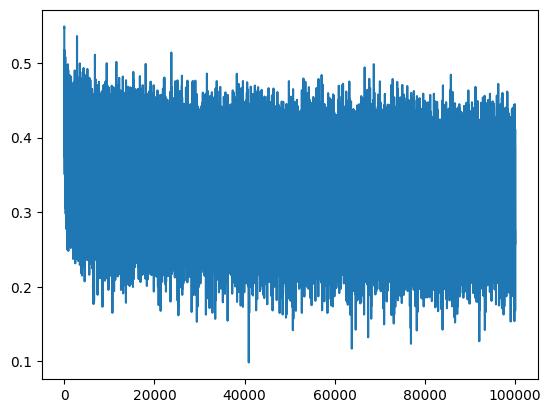

In [81]:
plt.plot(lossi)

In [82]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test),
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)

    print(f"{split}: {loss.item()}")


split_loss('train')
split_loss('val')

train: 2.086437463760376
val: 2.1427905559539795


In [83]:
# Sample from the model
with torch.no_grad():
    model.eval()
    for _ in range(10):
        out = []
        context = [0] * block_size
        while True:
            x = torch.tensor([context])
            logits = model(x)
            probs = F.softmax(logits, dim=1)

            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itos[i] for i in out[:-1]))

    model.train()

zand
zari
xekier
daviya
lins
ane
hatiye
nut
dyn
avee
